In [1]:
%matplotlib notebook
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
# First take a look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


<IPython.core.display.Javascript object>


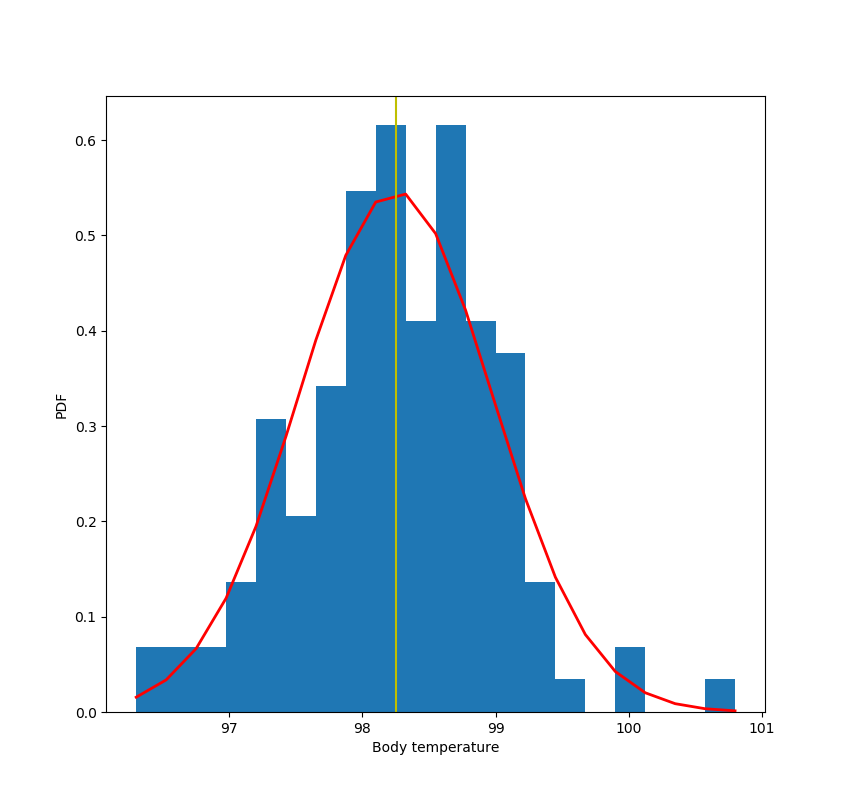

In [3]:
# The best way to take a closer look at the data is through some simple EDA
# We can try to test for normality using the graphical way
plt.figure(figsize=(8.5,8))
plt.subplot(1,1,1)
_, bins, _ = plt.hist(df.temperature,density=True,bins=20)
mu = np.mean(df.temperature)
sigma = np.std(df.temperature)
p = np.random.normal(mu, sigma,1000)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)), 
         linewidth=2, color='r')
plt.axvline(x=mu,color='y')
plt.xlabel('Body temperature')
plt.ylabel('PDF')
plt.show()
# Actually from our data the temperature seems "normal" in the sense where there is a visible amount of symmetry 

<IPython.core.display.Javascript object>


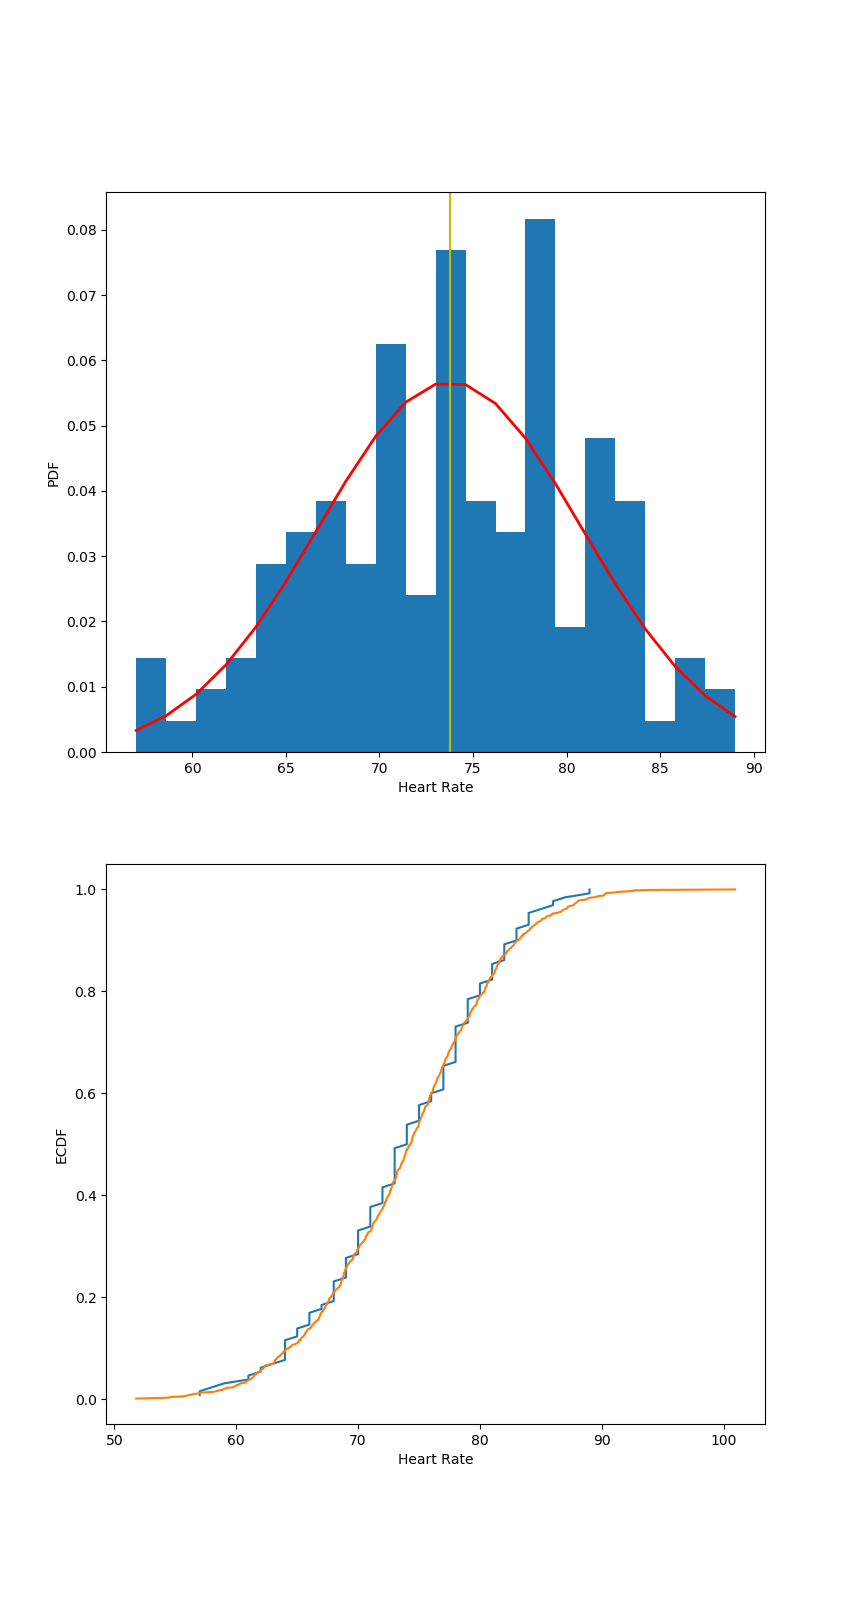

In [4]:
# Repeat the same analysis with the other two graphs to gain an understanding of both of them as well
plt.figure(figsize=(8.5,16))
plt.subplot(2,1,1)
count, bins, ignored = plt.hist(df.heart_rate,density=True,bins=20)
mu = np.mean(df.heart_rate)
sigma = np.std(df.heart_rate)
p = np.random.normal(mu, sigma,1000)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)), 
         linewidth=2, color='r')
plt.axvline(x=mu,color='y')
plt.xlabel('Heart Rate')
plt.ylabel('PDF')
plt.show()

# This set of data is harder to see, perhaps plotting it in cumulative distribution function will be easier to see
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1,n+1) / n

    return x, y
plt.subplot(2,1,2)
x,y = ecdf(df.heart_rate)
plt.xlabel('Heart Rate')
plt.ylabel('ECDF')
x_norm, y_norm = ecdf(p)
plt.plot(x,y)
plt.plot(x_norm,y_norm)
plt.show()
# From this we can see a sort of fit to the normal curve though with the amount of samples
# we have this is harder to determine

The p-value 2.19e-07 is lower than our significance level and thus we reject the null hypothesis.


<IPython.core.display.Javascript object>


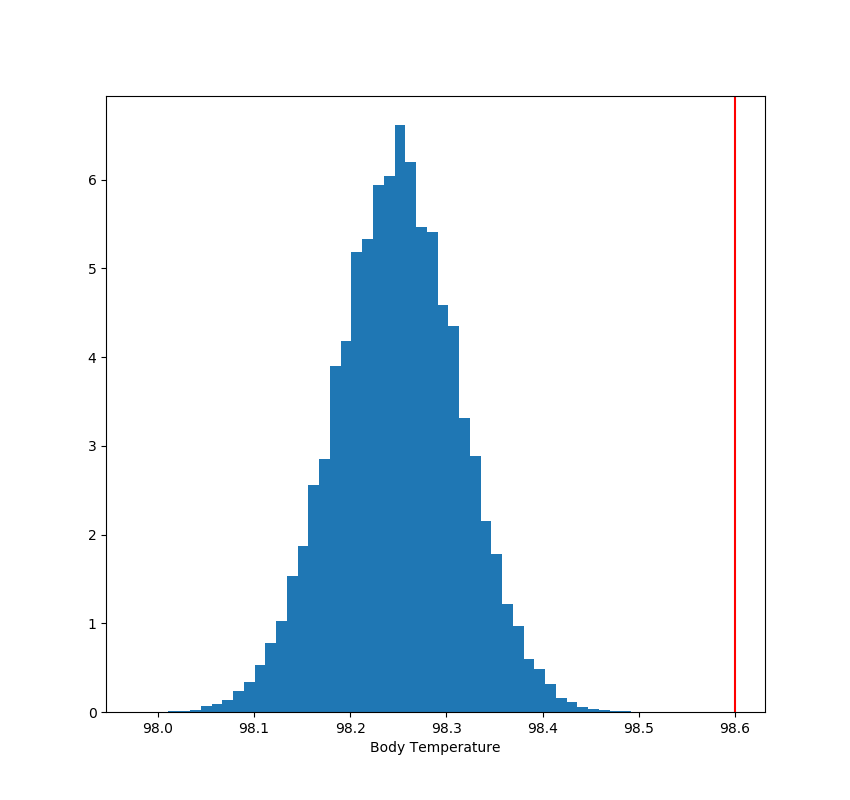

The hacked p-value 0.0 is lower than our significance level and thus we reject the null hypothesis.


In [5]:
# Determine if the true human body temperature is 98.6 first using statistics then using 
# hacker statistics through bootstrap sampling

null_h = 98.6
# Alternative hypothsis the heart rate is not 98.6 and the alpha/significance level is 0.05 or 5% 
alpha = 0.05
mu = np.mean(df.temperature)
sigma = np.std(df.temperature)
n = df.temperature.count()
t_val = (mu - null_h) / (sigma/np.sqrt(float(n)))
# Using t-value because we lack the standard deviation value for the population
p_val = stats.t.sf(np.abs(t_val), n-1)*2
# Another method given by scipy to provide
t2_val, p2_val = stats.ttest_1samp(df.temperature, null_h)
if(p_val < alpha):
    print(f"The p-value {np.round(p_val,9)} is lower than our significance level and thus we reject the null hypothesis.")
else:
    print(f"The p-value {np.round(p_val,9)} is higher than our significance level so we cannot reject the null hypothesis.")
    

# Lets see if we can use one sample  bootstrap testing to verify our conclusion
def draw_bs_reps(data, func, size=1):
    '''Use a one dimensional set of data to create an array of bootstrap replicates'''
    bs_replicates = np.empty(size)
    
    # Generate replicates by reorganizing the data then randomly selecting and replacing the data before running
    # the function on the data to create an array of bootstrap replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates
# We'll take 10000 resampled means to use as a test for p-value
bs_temp = draw_bs_reps(df.temperature,np.mean,50000)

_ = plt.figure(figsize=(8.5,8))
_ = plt.subplot(1,1,1)
plt.hist(bs_temp,bins=50,density=True)
plt.axvline(x=null_h,color='r')
plt.xlabel("Body Temperature")
plt.show()
# Although it looks fairly obvious with the graph, I will still calculate the p-value to show
# Calculate the p-value through determining the number of bootstrap replicates that are below the sample
hacked_p_value = np.sum(bs_temp>= null_h)/ len(bs_temp)

if(p_val < alpha):
    print(f"The hacked p-value {np.round(hacked_p_value,2)} is lower \
than our significance level and thus we reject the null hypothesis.")
else:
    print(f"The hacked p-value {np.round(hacked_p_value,2)} is higher \
than our significance level so we cannot reject the null hypothesis.")

In [6]:
# Determining difference of z-value vs t-value by using smaller sample size
small_temp_sample = np.random.choice(df.temperature, 10)

null_h = 98.6

mu = np.mean(small_temp_sample)
sigma = np.std(small_temp_sample)

z_val = (null_h - mu) / sigma
# Another method given by scipy to provide
t_val, p_val = stats.ttest_1samp(small_temp_sample, null_h)
print(f"The z-score of {round(z_val,3)} vs the t-score of {round(t_val,3)}")    
# There is a clear difference as the z-score is determined by assuming that our standard deviation from the
# small sample is equivalent to the population sample deviation

The z-score of 0.659 vs the t-score of -1.978


Interval found using mean and std from sample data: from 96.82 to 99.68 at a 95% confidence interval
Interval found using mean and std from bootstrap sample: from 96.74 to 99.48 at a 95% confidence interval


<IPython.core.display.Javascript object>


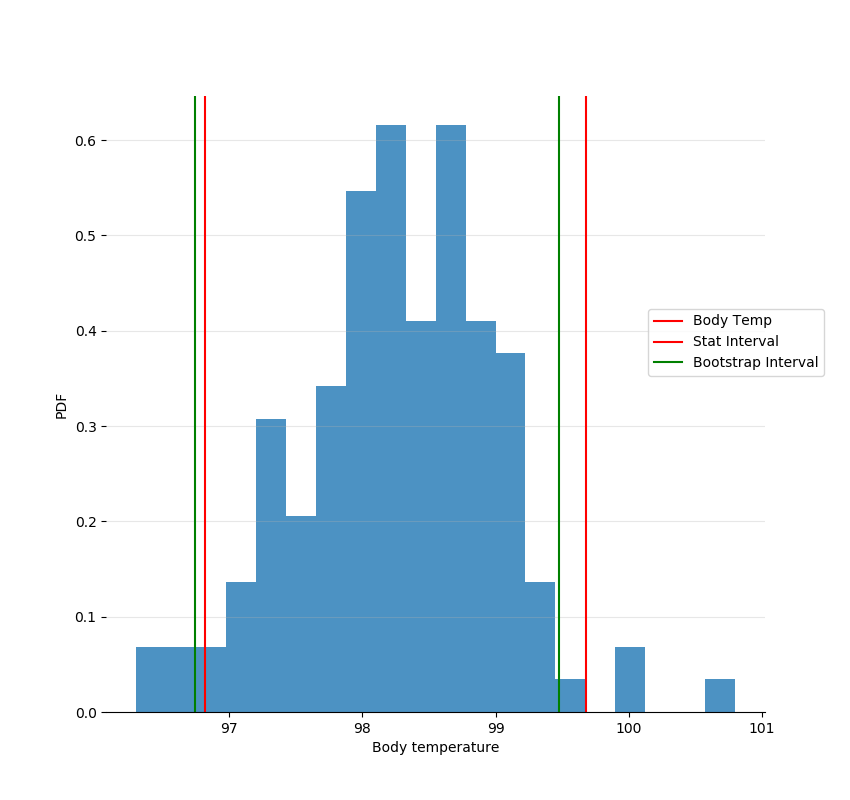

In [7]:
# Determine a confidence interval for body temperature using both the statistical method and using
# the bootstrap method. The interval will be set to 95% or from 2.5% to 97.5% on the z/t-table

# Interval using mean and std for known sample data
stat_interval = stats.norm.interval(0.95, loc=np.mean(df.temperature), scale=np.std(df.temperature))

# To find confidence interval, you are expected to use one draw from the data 
bs_temp = np.random.choice(df.temperature, size=len(df.temperature))
# Interval created by bootstrap sample 
bs_interval = np.percentile(bs_temp,[2.5,97.5])

print(f"Interval found using mean and std from sample data: from \
{round(stat_interval[0],2)} to {round(stat_interval[1],2)} at a 95% confidence interval")
# Notice that for the bootstrap sample you will get varying values because the sample is taken at random every time
print(f"Interval found using mean and std from bootstrap sample: \
from {round(bs_interval[0],2)} to {round(bs_interval[1],2)} at a 95% confidence interval")

# Plotting the intervals with original data to graphically show the interval ranges
fig = plt.figure(figsize=(8.5,8))
plt.subplot(1,1,1)
plt.hist(df.temperature,density=True,bins=20,alpha=.8)
plt.axvline(x=stat_interval[0],color='r')
plt.axvline(x=stat_interval[1],color='r')
plt.axvline(x=bs_interval[0],color='g')
plt.axvline(x=bs_interval[1],color='g')
plt.xlabel('Body temperature')
plt.ylabel('PDF')
plt.legend(["Body Temp","Stat Interval","Bootstrap Interval"],loc='right',bbox_to_anchor=(1.1,.6))
plt.grid(True,'both',alpha=.3,axis='y')
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
sns.despine(left=True)
plt.show()

In [8]:
# Is there a significant difference between male and female body temperatures?
# Lets use the null hypothesis of the values have no significant difference 

gender_mean = df.groupby('gender').agg('mean')
gender_std = df.groupby('gender').agg('std')

female_mean = gender_mean.loc['F','temperature']
female_std = gender_std.loc['F','temperature']
male_mean = gender_mean.loc['M','temperature']
male_std = gender_std.loc['M','temperature']
female_count = np.sum(df.gender == "F")
male_count = np.sum(df.gender == "M")
diff_mean = female_mean - male_mean
diff_std = np.sqrt((female_std**2/female_count) + (male_std**2/male_count))
# This is the z-value for the significance level of 5%
Z_VAL_TWO_STD = 1.96
conf_val = Z_VAL_TWO_STD * diff_std
# So if we assume the difference between male and female temperatures on average is zero than the confidence interval
# is -conf_val to +conf_val 95% of the time
conf_interval = (-round(conf_val,4) + diff_mean,+round(conf_val,4) + diff_mean)
# We set the null hypothesis to be zero to state that we are not expecting any difference in male and female body temps
null_h = 0;
if((null_h >= conf_interval[0]) & (null_h <=conf_interval[1])):
   print(f"Since the null hypothesis {round(null_h,2)} lies within the \
confidence interval {conf_interval}, we cannot reject the null hypothesis.")
else:
   print(f"Since the null hypothesis {round(null_h,2)} is outside of the \
confidence interval {conf_interval}, we reject the null hypothesis and find that \
the female and male body temperatures are not equal.")

Since the null hypothesis 0 is outside of the confidence interval (0.041230769230726994, 0.537230769230727), we reject the null hypothesis and find that the female and male body temperatures are not equal.


<IPython.core.display.Javascript object>


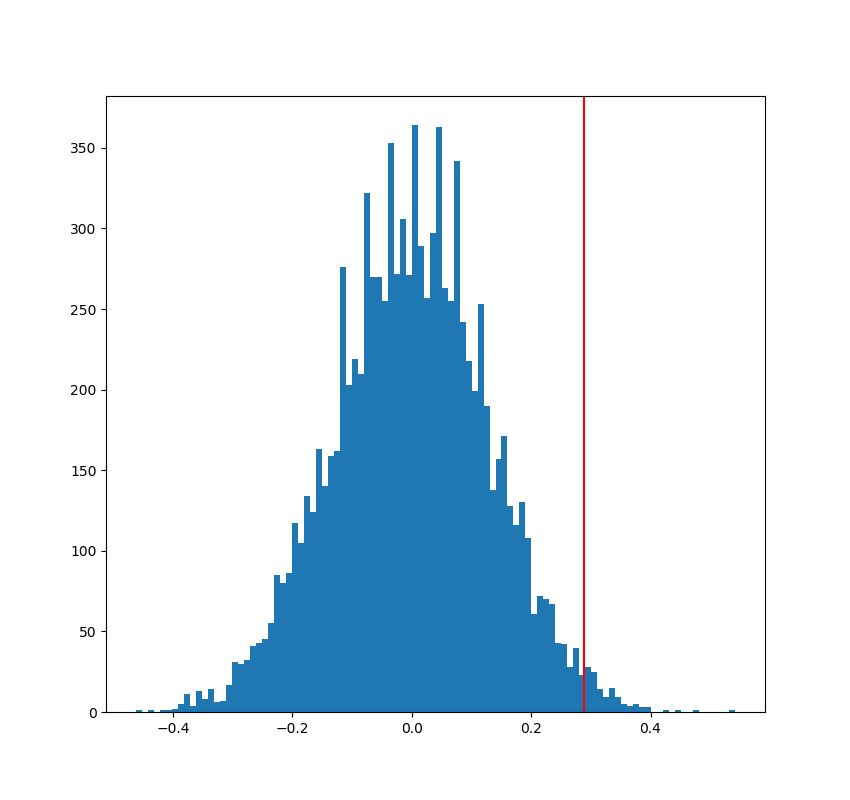

Our simulated p-value is 0.013 which is lower than our significance level (0.05) and matches out previous conclusion.


In [9]:
# To check the conclusion above, I will perform the same examination using permutation and bootstrapping
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

bs_gender_mean = draw_perm_reps(np.array(df.loc[df.gender == "M",'temperature']),
                                np.array(df.loc[df.gender == "F",'temperature']),
                                lambda a,b: np.mean(a)-np.mean(b),10000)
_ = plt.figure(figsize=(8.5,8))
_ = plt.subplot(1,1,1)
_ = plt.hist(bs_gender_mean,bins=100)
p_value = np.sum(bs_gender_mean >= diff_mean) / len(bs_gender_mean)
plt.axvline(x=diff_mean,color='r')
plt.show()
if(p_value <= 0.05):
    print(f"Our simulated p-value is {p_value} which is lower than \
our significance level (0.05) and matches out previous conclusion.")        